In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from collections import Counter
import operator

In [4]:
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, plot_roc_curve, auc

In [5]:
from imblearn.over_sampling import SMOTE
from yellowbrick.regressor import ResidualsPlot
from sklearn.inspection import permutation_importance

In [61]:
rfc_data = pd.read_csv('FeatureSelectedRFC.csv', index_col=0)
etc_data = pd.read_csv('FeatureSelectedETC.csv', index_col=0)

In [63]:
X_fs_rfc = rfc_data.drop(['Dose', 'Binary'], axis=1)
X_fs_etc = etc_data.drop(['Dose', 'Binary'], axis=1)
y_1_2_bin = etc_data['Binary']
y_1_2 = etc_data['Dose']

In [7]:
cmap = sns.color_palette("hls", 2)

### Binary Classification
#### Basic Model

In [8]:
def mc_model_cv_noprint(model, X_full, y_full, n_folds):
    """
    Performs n-fold cross validation, for use with iteration function
    ---------------------------------------------------
    
    Arguments
    model - Classifier model (with any required arguments)
    X_full - Full feature dataset (with target removed)
    y_full - Predicted variable 
    n-folds - Number of folds to use in CV
    
    Returns
    CV Accuracy, accuracy score
    """

    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=4444)
    model.fit(X_train, y_train)
    y_p = model.predict(X_test)
    y_p_train = model.predict(X_train)
    
    
    cv_s = list(cross_val_score(model, X_full, y_full, cv=n_folds))
    av_cv_s = sum(cv_s)/n_folds
    ac_s = accuracy_score(y_test, y_p)
    auc_s = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    return av_cv_s, ac_s, auc_s

In [9]:
def cv_make_iter(n_iter, n_folds, rfc_X, etc_X, y):
    rfc_cv = 0
    rfc_acc = 0

    etc_cv = 0
    etc_acc = 0

    for i in range(n_iter):
        print("\r", 'Progress: ' + '#'*(i+1), end="")
        rfc_model = mc_model_cv_noprint(rfc, rfc_X, y, n_folds)
        rfc_cv += rfc_model[0]
        rfc_acc += rfc_model[1]

        etc_model = mc_model_cv_noprint(etc, etc_X, y, n_folds)
        etc_cv += etc_model[0]
        etc_acc += etc_model[1]

    print('\n')
    print('RFC average CV score over', n_iter, 'iterations (', rfc_X.shape[1], 'features ):', rfc_cv/n_iter)
    print('RFC average Accuracy score over', n_iter, 'iterations (', rfc_X.shape[1], 'features ):', rfc_acc/n_iter)
    print('\n')
    print('ETC average CV score over', n_iter, 'iterations (', etc_X.shape[1], 'features ):', etc_cv/n_iter)
    print('ETC average Accuracy score over', n_iter, 'iterations (', etc_X.shape[1], 'features ):', etc_acc/n_iter)

In [10]:
rfc = RandomForestClassifier(n_estimators=800)
etc = ExtraTreesClassifier(n_estimators=800)

In [11]:
mc_model_cv_noprint(rfc, X_fs_rfc, y_1_2_bin, 5)
mc_model_cv_noprint(etc, X_fs_etc, y_1_2_bin, 5)

(0.851063829787234, 0.9154929577464789, 0.9369047619047619)

In [12]:
cv_make_iter(10, 5, X_fs_rfc, X_fs_etc, y_1_2_bin)

 Progress: ##########

RFC average CV score over 10 iterations ( 1586 features ): 0.8570212765957445
RFC average Accuracy score over 10 iterations ( 1586 features ): 0.9112676056338026


ETC average CV score over 10 iterations ( 1861 features ): 0.8514893617021277
ETC average Accuracy score over 10 iterations ( 1861 features ): 0.9112676056338028


### SMOTE to balace classes

In [14]:
sm = SMOTE(random_state=42)
X_r, y_r = sm.fit_resample(X_fs_rfc, y_1_2_bin)

sm = SMOTE(random_state=42)
X_r_2, y_r_2 = sm.fit_resample(X_fs_etc, y_1_2_bin)

#### BEST MODEL SO FAR

In [19]:
mc_model_cv_noprint(rfc, X_r, y_r, 5)

(0.9510551647537948, 0.9818181818181818, 0.9993333333333333)

### Confusion Matrix

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, random_state=0)

In [17]:
classifier = rfc.fit(X_train, y_train)

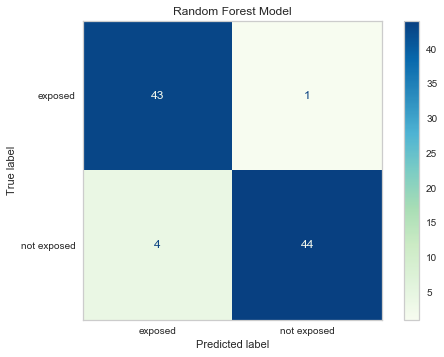

In [18]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                      display_labels=classifier.classes_,
                      cmap=plt.cm.GnBu)
disp.ax_.set_title('Random Forest Model')
plt.grid(False)
plt.show()

### PCA to Visualize SMOTE

In [20]:
pca = PCA(n_components=2)

In [21]:
comb_pca = pd.DataFrame(pca.fit_transform(X_fs_rfc), columns=['PC1', 'PC2'])
comb_pca['Dose'] = y_1_2_bin

Text(0.5, 1.0, 'Before SMOTE')

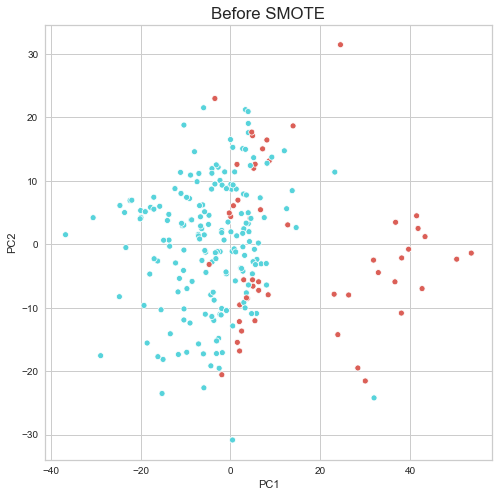

In [22]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='w')
sns.set(style='whitegrid', font_scale=1.4)
sns.scatterplot(data=comb_pca, x='PC1', y='PC2', hue='Dose', palette=cmap, legend=False).set_title('Before SMOTE')

In [23]:
comb_pca = pd.DataFrame(pca.fit_transform(X_r), columns=['PC1', 'PC2'])
comb_pca['Dose'] = y_r

Text(0.5, 1.0, 'After SMOTE')

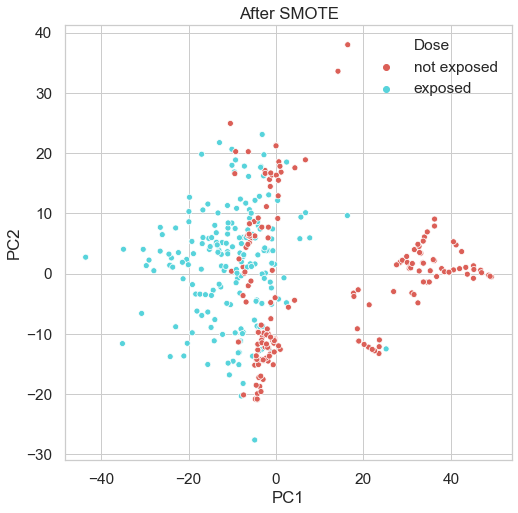

In [24]:
fig, ax = plt.subplots(figsize=(8,8), facecolor='w')
sns.set(style='whitegrid', font_scale=1.4)
sns.scatterplot(data=comb_pca, x='PC1', y='PC2', hue='Dose', palette=cmap).set_title('After SMOTE')

### ROC AUC Curve

In [25]:
X = np.array(X_r)
y = np.array(y_r)

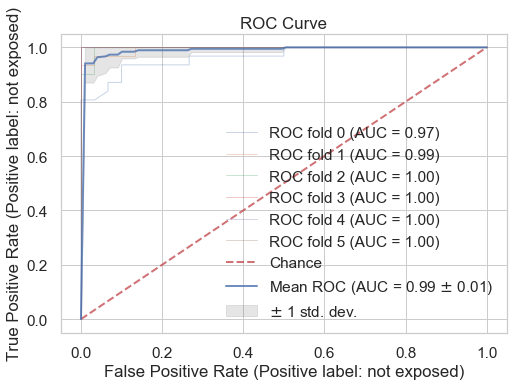

In [26]:
cv = StratifiedKFold(n_splits=6)
classifier = rfc

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve")
ax.legend(loc="lower right")
plt.show()

### Feature extraction

In [32]:
def cv_feat_extraction(model, X_full, y_full, n_folds, n_features):
    """
    Performs n-fold cross validation and extracts n-features using 
    permutation importance for downstream analyses
    ---------------------------------------------------
    
    Arguments
    model - Classifier model (with any required arguments)
    X_full - Full feature dataset (with target removed)
    y_full - Predicted variable 
    n_folds - Number of folds to use in CV
    n_features - Number of features to extract
    
    Returns
    CV Accuracy, accuracy score, AUC of ROC
    """

    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=4444)
    model.fit(X_train, y_train)
    y_p = model.predict(X_test)
    y_p_train = model.predict(X_train)
    
    
    cv_s = list(cross_val_score(model, X_full, y_full, cv=n_folds))
    av_cv_s = sum(cv_s)/n_folds
    ac_s = accuracy_score(y_test, y_p)
    auc_s = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    sig_feat = model.feature_importances_
    
    print('accuracy:', av_cv_s, 'CV score:', ac_s, 'AUC:', auc_s)
    return sig_feat

In [33]:
test = cv_feat_extraction(rfc, X_r, y_r, 5, 100)

accuracy: 0.964679748241392 CV score: 0.9727272727272728 AUC: 0.9988333333333334


In [34]:
top_100 = sorted(list(zip(X_fs_rfc.columns, test)), reverse=True, key=lambda x: x[1])[0:100]

In [35]:
top_100[0:10]

[('8795', 0.022365617501100617),
 ('6468', 0.015151860051723573),
 ('27113', 0.010554824698053434),
 ('3590', 0.010327335678014148),
 ('5293', 0.00944868087154157),
 ('6434', 0.008862944051755355),
 ('3241', 0.008791029931734959),
 ('2232', 0.008326094217973002),
 ('9416', 0.008036537596636419),
 ('51170', 0.007747228756273892)]

In [36]:
pickle.dump(top_100, open('top_100_040721.p', 'wb'))

In [37]:
gn = pd.read_csv('t_040721_gene_names.txt', delimiter='\t')
gn = gn.drop('Species', axis=1)

In [38]:
gn

,ENTREZ_GENE_ID,Name
0,3590,interleukin 11 receptor subunit alpha(IL11RA)
1,23559,WW domain binding protein 1(WBP1)
2,25865,protein kinase D2(PRKD2)
3,113419,testis expressed 261(TEX261)
4,522,"ATP synthase, H+ transporting, mitochondrial F..."
...,...,...
95,752,formin like 1(FMNL1)
96,79603,ceramide synthase 4(CERS4)
97,64763,zinc finger protein 574(ZNF574)
98,5885,RAD21 cohesin complex component(RAD21)


In [39]:
rank = [int(x[0]) for x in top_100]

In [40]:
rank_df = pd.DataFrame(rank)
rank_df[1] = list(range(1, 101))

In [41]:
sorted_gn = (gn
             .merge(rank_df, left_on='ENTREZ_GENE_ID', right_on=0)
             .drop(0, axis=1)
             .sort_values(by=1))

In [42]:
sorted_gn.to_csv('040721_sorted.tsv', index=False, sep='\t')

### Constrain gene columns to data search results

In [93]:
full_data = pd.read_csv('GSE6987_GSE43151.csv', index_col=0)

In [96]:
X = full_data.drop(['Dose', 'Binary', 'Dataset'], axis=1)
y = full_data['Binary']

### SMOTE

In [97]:
sm = SMOTE(random_state=42)
X_r, y_r = sm.fit_resample(X, y)

In [98]:
lit_selection = (['5859', '3376', '51520', '5917', '4141', '23077', '7534', 
                  '2355', '894', '545', '4193', '9451', '7494', '9261', 
                  '8202', '902', '317781', '23586', '57696', '83479', '317781', 
                  '5705', '5704', '6502', '9861', '4193', '5707', '3106', 
                  '3590', '3570', '3601', '3575', '3611', '56647', '25792', 
                  '311', '581', '8550', '8649', '9261', '9479', '79109', '5594', 
                  '5598', '5600', '5603', '5604', '23542', '7867', '5902', 
                  '1984', '38', '645', '5518', '55256', '1737', '1384', '1495', 
                  '1282', '1284', '1289', '1291', '1292', '1300', '1302', '1307', 
                  '10087', '85301', '5118', '136227', '80781', '7168', '7170', '1385', 
                  '10488', '6772', '489', '4714', '2597', '6125', '23471', '7037', 
                  '2058', '3988', '10558', '25800', '4121', '963', '81539', '953', 
                  '60481', '8635', '29880', '3106', '7779', '483', '9522', '1829', 
                  '962', '931', '6185', '6505', '57205', '754', '3161', '3156', '1690', 
                  '2734', '10269', '10618', '9044', '10549', '6745', '965', '51809', 
                  '8763', '10721', '23443', '10561', '8836', '6653', '3895', '81671', 
                  '9375', '6713', '5788', '5066'])

In [99]:
lit_selection = list(set(lit_selection))

In [101]:
X_ls = pd.DataFrame(data=X_r, columns=lit_selection)
X_ls = X_ls.dropna(axis='columns')
y_ls = y_r

### Lit Selected Model

In [102]:
mc_model_cv_noprint(rfc, X_ls, y_ls, 5)

(0.9429100333209922, 0.9636363636363636, 0.9969999999999999)

### Random Selection (sanity check)

In [109]:
import random

In [116]:
X_rand = pd.DataFrame(data=X_r, columns=random.sample(set(X.columns), 105))
y_rand = y_r

In [119]:
mc_model_cv_noprint(rfc, X_rand, y_rand, 5)

(0.9374305812661976, 0.9090909090909091, 0.985)